# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app", seed = 123)
# env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", seed = 123)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.          1.          0.          0.          0.34538859  0.          1.
  0.          0.          0.59930861  0.          0.          1.          0.
  0.02931019  0.          1.          0.          0.          0.34140164
  0.          0.          1.          0.          0.05138472  0.          0.
  1.          0.          0.29204866  0.          0.          1.          0.
  0.29252312  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# env = UnityEnvironment(file_name="Banana.app")

In [8]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import time

from agent_dqn_prioritized import Agent  

# retrieve the action_size and state_size 
env_info = env.reset(train_mode = True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

In [9]:
### this cell is for training the agent 

# hyper-parameters for training the model 
THRESHOLD_SCORE = 18.0 # threshold of score for terminating the training 
SOLVED_SCORE = 13.0 # threshold for solving the environment
DISPLAY_EVERY = 50 # averege score (over last 100 episodes) is displayed every DISPLAY_EVERY episoldes
NUM_EPISODES = 1000 # number of episodes for training
MAX_T = 1000 # maximum number of time steps for each episode 
EPS_START = 1.0 # initial value of the epsilon for epsilon-greedy algorithm
EPS_END = 0.01 # minimum value of the epsilon for the epsilon-greedy algorithm 
EPS_DECAY = 0.99 # decay rate of the epsilon for the epsilon-greedy algorithm 

def train_model(num_episodes, max_t, eps_start, eps_end, eps_decay, 
                            is_double_Q, is_prioritized, file_name = "check_point.pth"):
    """
    This function is for training Q-learning model. 
    
    (input)
    - num_episode (int): number of episodes for training 
    - max_t (int): maximum number of time steps for each episode 
    - eps_start (float): initial value of the epsilon for epsilon-greedy algorithm 
    - eps_end (float): minimum value of the epsilon for the epsilon-greedy algorithm 
    - eps_decay (float): decay rate of the epsilon for the epsilon-greedy algorithm 
    - is_double_Q (bool): double Q-learning (True) or normal Q-learning (False)
    - is_prioritized (bool): prioritized replay buffer (True) or normal replay buffer (False)
    
    (output)
    trained agent, list of raw scores for episodes, list of average scores (over last 100 episodes)  
    
    """
    
    # build an agent 
    agent = Agent(state_size, action_size, is_double_Q, is_prioritized, seed = 1)
    
    scores = [] # for storing final scores of all the episodes
    scores_ave = [] # for storing average scores from the last 100 episodes
    scores_window = deque(maxlen = 100) # for storing final scores for the last 100 episodes
    best_average_score = 0.0 # best average score over the last 100 episodes
    best_i_episode = 1 # the episode number in which the best average score is reached
    is_solved = False # if the environment has been solved or not 
    eps = eps_start # set the initial value for the epsilon for the epsilon-greedy algorithm 
    
    print('----- training started! -----')
    start_time = time.time() # for measuring the elapsed time 
    
    for i_episode in range(1, num_episodes+1):
        
        # reset the environment and take an initial state 
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        
        # initialize the score for the current episode 
        score = 0.0
        
        for t in range(max_t):
             
            action  = agent.act(state, eps) # choose the action 
            env_info = env.step(action)[brain_name] # send the action to the environment
            reward = env_info.rewards[0] # get the reward 
            next_state = env_info.vector_observations[0] # get the next state
            done = env_info.local_done[0] # see if the episode is done or not       
            agent.step(state, action, reward, next_state, done) # update of the agent 
            score += reward 
            state = next_state 
            
            if done: # if the episode has ended
                break 
        
        # save the score of the current episode to scores and scores_window
        scores.append(score)
        scores_window.append(score)
        
        # average score over the last 100 episodes
        average_score = np.mean(scores_window) 
        scores_ave.append(average_score)
        
        # update the epsilon for the epsilon-greedy
        eps = max(eps_end, eps*eps_decay)
        # # use the below instead for another way to update the epsilon for the epsilon-greedy algorithm 
        # eps = eps_end + (eps_start - eps_end)/i_episode

        # if the episode is solved or not
        if (average_score > SOLVED_SCORE) and (is_solved == False) :
            print("----- environment solved at episode {} average score: {:.2f} -----".format(i_episode, average_score))
            is_solved = True
            
        # save the model if the best average score is achieved
        if average_score > best_average_score:
            best_average_score = average_score
            best_i_episode = i_episode
            torch.save(agent.qnetwork_local.state_dict(), file_name)
            
        # display the average score every DISPLAY_EVERY episodes
        if i_episode % DISPLAY_EVERY == 0:
            
            end_time = time.time()
            print("----- episode {} average score: {:.2f} -----".format(i_episode, average_score))
            # print("loss: ", agent.loss.data.cpu().numpy())
            print("elapsed time: {:.2f}".format(end_time-start_time))
            
            # initialize the start time for the next episode    
            start_time = time.time()
        
        # terminate the training if the avarage score becomes above THRESHOLD_SCORE  
        if average_score > THRESHOLD_SCORE:
            
            print('----- training terminated! -----')
            print("environment terminated at {:d} episode. average score {}".format((i_episode-DISPLAY_EVERY), average_score))   
            
            break 
        
    print('----- best average score: {:.2f} at {:d} epsiode -----'.format(best_average_score, best_i_episode))
    return agent, scores, scores_ave

In [10]:
# train the model (standard Q-learning with standard replay buffer)
agent_1, scores_1, scores_ave_1 = train_model(NUM_EPISODES, MAX_T, EPS_START, EPS_END, EPS_DECAY, 
                                            is_double_Q = False, is_prioritized = False, file_name = "check_point_1.pth")

----- training started! -----
----- episode 50 average score: 0.60 -----
elapsed time: 53.54
----- episode 100 average score: 2.24 -----
elapsed time: 53.93
----- episode 150 average score: 6.74 -----
elapsed time: 54.25
----- episode 200 average score: 10.98 -----
elapsed time: 58.51
----- episode 250 average score: 12.57 -----
elapsed time: 57.12
----- environment solved at episode 278 average score: 13.04 -----
----- episode 300 average score: 13.64 -----
elapsed time: 57.46
----- episode 350 average score: 15.25 -----
elapsed time: 55.94
----- episode 400 average score: 15.27 -----
elapsed time: 55.76
----- episode 450 average score: 14.68 -----
elapsed time: 56.15
----- episode 500 average score: 14.96 -----
elapsed time: 56.04
----- episode 550 average score: 14.94 -----
elapsed time: 55.86
----- episode 600 average score: 15.49 -----
elapsed time: 56.20
----- episode 650 average score: 15.47 -----
elapsed time: 56.21
----- episode 700 average score: 14.97 -----
elapsed time: 55.

In [11]:
# train the model (double Q-learning with standard replay buffer)
agent_2, scores_2, scores_ave_2 = train_model(NUM_EPISODES, MAX_T, EPS_START, EPS_END, EPS_DECAY, 
                                            is_double_Q = True, is_prioritized = False, file_name = "check_point_2.pth")

----- training started! -----
----- episode 50 average score: 0.86 -----
elapsed time: 57.44
----- episode 100 average score: 2.57 -----
elapsed time: 58.44
----- episode 150 average score: 5.72 -----
elapsed time: 59.34
----- episode 200 average score: 9.52 -----
elapsed time: 59.14
----- episode 250 average score: 12.06 -----
elapsed time: 59.67
----- episode 300 average score: 12.70 -----
elapsed time: 59.84
----- environment solved at episode 318 average score: 13.02 -----
----- episode 350 average score: 13.37 -----
elapsed time: 60.26
----- episode 400 average score: 13.67 -----
elapsed time: 60.38
----- episode 450 average score: 13.89 -----
elapsed time: 60.29
----- episode 500 average score: 14.40 -----
elapsed time: 60.49
----- episode 550 average score: 14.61 -----
elapsed time: 60.43
----- episode 600 average score: 15.29 -----
elapsed time: 60.49
----- episode 650 average score: 15.75 -----
elapsed time: 60.59
----- episode 700 average score: 15.67 -----
elapsed time: 60.5

In [12]:
# train the model (Q-learning with prioritized replay buffer)
agent_3, scores_3, scores_ave_3 = train_model(NUM_EPISODES, MAX_T, EPS_START, EPS_END, EPS_DECAY, 
                                            is_double_Q = False, is_prioritized = True, file_name = "check_point_3.pth")

----- training started! -----
----- episode 50 average score: 1.26 -----
elapsed time: 64.02
----- episode 100 average score: 3.63 -----
elapsed time: 78.13
----- episode 150 average score: 9.02 -----
elapsed time: 92.03
----- episode 200 average score: 12.73 -----
elapsed time: 110.86
----- environment solved at episode 214 average score: 13.03 -----
----- episode 250 average score: 13.97 -----
elapsed time: 138.84
----- episode 300 average score: 14.58 -----
elapsed time: 175.10
----- episode 350 average score: 14.99 -----
elapsed time: 209.26
----- episode 400 average score: 15.40 -----
elapsed time: 220.76
----- episode 450 average score: 15.63 -----
elapsed time: 224.71
----- episode 500 average score: 15.80 -----
elapsed time: 225.68
----- episode 550 average score: 15.49 -----
elapsed time: 233.61
----- episode 600 average score: 15.15 -----
elapsed time: 228.10
----- episode 650 average score: 15.12 -----
elapsed time: 246.66
----- episode 700 average score: 15.08 -----
elapsed

In [13]:
# train the model (double Q-learning with prioritized replay buffer)
agent_4, scores_4, scores_ave_4 = train_model(NUM_EPISODES, MAX_T, EPS_START, EPS_END, EPS_DECAY, 
                                            is_double_Q = True, is_prioritized = True, file_name = "check_point_4.pth")

----- training started! -----
----- episode 50 average score: 0.38 -----
elapsed time: 68.53
----- episode 100 average score: 1.62 -----
elapsed time: 81.81
----- episode 150 average score: 5.84 -----
elapsed time: 96.09
----- episode 200 average score: 10.04 -----
elapsed time: 116.43
----- episode 250 average score: 12.68 -----
elapsed time: 141.90
----- environment solved at episode 262 average score: 13.04 -----
----- episode 300 average score: 14.49 -----
elapsed time: 176.83
----- episode 350 average score: 15.20 -----
elapsed time: 212.93
----- episode 400 average score: 15.73 -----
elapsed time: 224.01
----- episode 450 average score: 15.83 -----
elapsed time: 224.83
----- episode 500 average score: 16.06 -----
elapsed time: 231.15
----- episode 550 average score: 15.83 -----
elapsed time: 225.54
----- episode 600 average score: 15.22 -----
elapsed time: 226.36
----- episode 650 average score: 15.32 -----
elapsed time: 227.09
----- episode 700 average score: 15.51 -----
elapsed

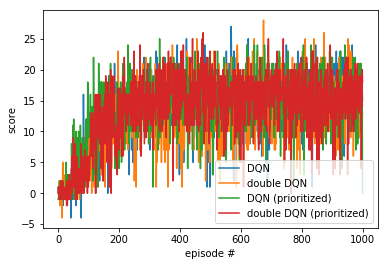

In [14]:
### plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_1)), scores_1, label="DQN")
plt.plot(np.arange(len(scores_2)), scores_2, label="double DQN")
plt.plot(np.arange(len(scores_3)), scores_3, label="DQN (prioritized)")
plt.plot(np.arange(len(scores_4)), scores_4, label="double DQN (prioritized)")
plt.ylabel('score')
plt.xlabel('episode #')
plt.legend()
plt.savefig('scores.eps')
plt.show()

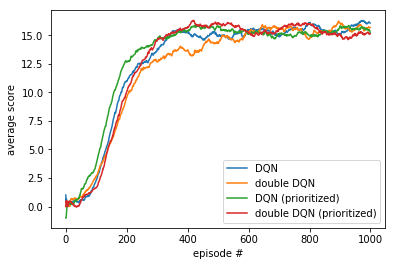

In [15]:
### plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ave_1)), scores_ave_1, label="DQN")
plt.plot(np.arange(len(scores_ave_2)), scores_ave_2, label="double DQN")
plt.plot(np.arange(len(scores_ave_3)), scores_ave_3, label="DQN (prioritized)")
plt.plot(np.arange(len(scores_ave_4)), scores_ave_4, label="double DQN (prioritized)")
plt.ylabel('average score')
plt.xlabel('episode #')
plt.legend()
plt.savefig('scores_average.eps')
plt.show()

In [19]:
### display the performance of the trained model

# reset the environment and take initial state 
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]  

# some information of the model to load
file_name_weights = 'check_point_4.pth'
agent = agent_4

# load the model with the best score 
agent.qnetwork_local.load_state_dict(torch.load(file_name_weights))

agent.reset()
score = 0  # initialize the score
while True:
    action = agent.act(state, eps =0.0) # choose an action based on the model 
    env_info = env.step(action)[brain_name] # send the action to the environment
    next_state = env_info.vector_observations[0] # get the next state
    reward = env_info.rewards[0] # get the reward
    done = env_info.local_done[0] # see if episode has finished
    
    score += reward 
    state = next_state 
    
    if done:
        break
    
print("score: {}".format(score))

score: 17.0


In [20]:
env.close()